## Regression modelling exercises

19 January 2023

In [43]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from math import sqrt

from sklearn.linear_model import LinearRegression
from sklearn.linear_model import TweedieRegressor

from sklearn.metrics import mean_squared_error, r2_score, explained_variance_score

from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PolynomialFeatures

from sklearn.feature_selection import SelectKBest, f_regression, RFE

from env import host, username, password, sql_connexion
import env

# import my functions
import project_2_acquire_zillow_function
import project_2_prepare_zillow_2017

# turn off pink warning boxes
import warnings
warnings.filterwarnings("ignore")


**1. Select a dataset with a continuous target variable.**  
**2. Be sure your data is prepared (no missing values, numeric datatypes) and split into samples.**

### Prepare

In [2]:
# obtaining the prepared Telco dataset.

zil = project_2_acquire_zillow_function.get_zillow_2017_data(env.sql_connexion)

zil.head()


,parcelid,transactiondate,bathroomcnt,bedroomcnt,calculatedfinishedsquarefeet,fips,taxvaluedollarcnt
0,14297519,2017-01-01,3.5,4.0,3100.0,6059.0,1023282.0
1,17052889,2017-01-01,1.0,2.0,1465.0,6111.0,464000.0
2,14186244,2017-01-01,2.0,3.0,1243.0,6059.0,564778.0
3,12177905,2017-01-01,3.0,4.0,2376.0,6037.0,145143.0
4,12095076,2017-01-01,3.0,4.0,2962.0,6037.0,773303.0


In [3]:
# looking at the shape

zil.shape



(52442, 7)

**The dataframe has 52 442 rows and 7 columns.**


In [4]:
# what's in the df 

zil.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 52442 entries, 0 to 52441
Data columns (total 7 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   parcelid                      52442 non-null  int64  
 1   transactiondate               52442 non-null  object 
 2   bathroomcnt                   52442 non-null  float64
 3   bedroomcnt                    52442 non-null  float64
 4   calculatedfinishedsquarefeet  52360 non-null  float64
 5   fips                          52442 non-null  float64
 6   taxvaluedollarcnt             52441 non-null  float64
dtypes: float64(5), int64(1), object(1)
memory usage: 2.8+ MB


In [5]:
# finding nulls

zil.isnull().sum()

parcelid                         0
transactiondate                  0
bathroomcnt                      0
bedroomcnt                       0
calculatedfinishedsquarefeet    82
fips                             0
taxvaluedollarcnt                1
dtype: int64

In [34]:
# renaming unsightly column names

zil = zil.rename(columns = {'bedroomcnt' : 'num_br', 'bathroomcnt' : 'num_ba', 
                            'calculatedfinishedsquarefeet' : 'total_sqft', 
                            'transactiondate' : 'date_sold', 
                            'taxvaluedollarcnt' : 'tax_val', 
                           'fips' : 'county_fips'})

zil.head()

,date_sold,num_ba,num_br,total_sqft,county,tax_val
0,2017-01-01,3.5,4.0,3100.0,6059,1023282.0
1,2017-01-01,1.0,2.0,1465.0,6111,464000.0
2,2017-01-01,2.0,3.0,1243.0,6059,564778.0
3,2017-01-01,3.0,4.0,2376.0,6037,145143.0
4,2017-01-01,3.0,4.0,2962.0,6037,773303.0


In [8]:
# filling na spaces with 0

zil = zil.fillna(0)

In [9]:
zil.isnull().sum()

date_sold     0
num_ba        0
num_br        0
total_sqft    0
county        0
tax_val       0
dtype: int64

In [20]:
# checking to see how many houses have a sq ft of 0

zil[zil.total_sqft == 0].value_counts().sum()

82

In [22]:
# dropping houses with 0 sq ft

zil = zil[zil.total_sqft > 0]
zil.shape

(52360, 6)

In [23]:
# houses with no bathroom

zil[zil.num_ba == 0].value_counts().sum()

47

In [25]:
# dropping houses with 0 bathrooms

zil = zil[zil.num_ba > 0]
zil.shape

(52313, 6)

In [26]:
# dropping houses with 0 tax value

zil = zil[zil.tax_val > 0]
zil.shape

(52312, 6)

In [7]:
# dropping unneeded column 'parcel_id'

zil = zil.drop(columns = ['parcelid'], axis = 0)
zil.head()

,date_sold,num_ba,num_br,total_sqft,county,tax_val
0,2017-01-01,3.5,4.0,3100.0,6059.0,1023282.0
1,2017-01-01,1.0,2.0,1465.0,6111.0,464000.0
2,2017-01-01,2.0,3.0,1243.0,6059.0,564778.0
3,2017-01-01,3.0,4.0,2376.0,6037.0,145143.0
4,2017-01-01,3.0,4.0,2962.0,6037.0,773303.0


In [31]:
# changing county (FIPS code) to an integer

zil = zil.astype({'county':'int64'})
zil.head()

In [48]:
#drop duplicates
zil.drop_duplicates(inplace = True)

In [49]:
# now the data is cleaned up a bit : no more nulls, columns renamed, ZIP code is an integer value

zil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50937 entries, 0 to 52441
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_sold   50937 non-null  object 
 1   num_ba      50937 non-null  float64
 2   num_br      50937 non-null  float64
 3   total_sqft  50937 non-null  float64
 4   county      50937 non-null  int64  
 5   tax_val     50937 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.7+ MB


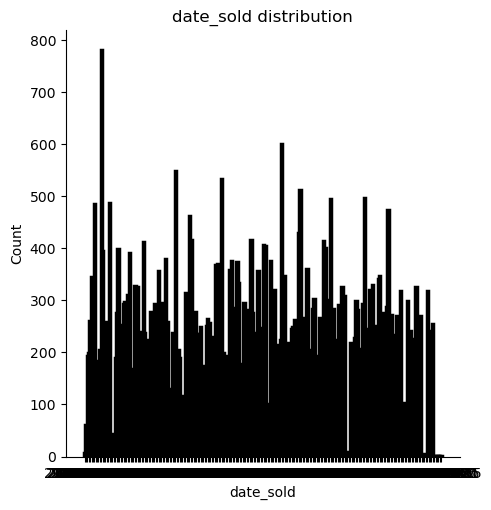

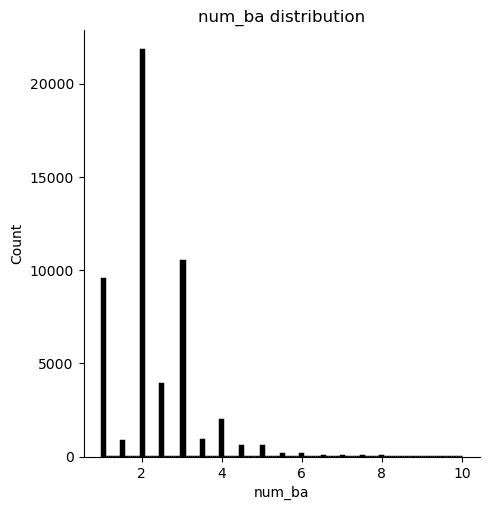

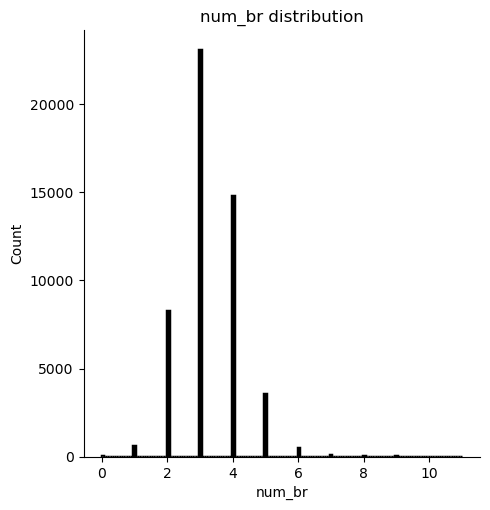

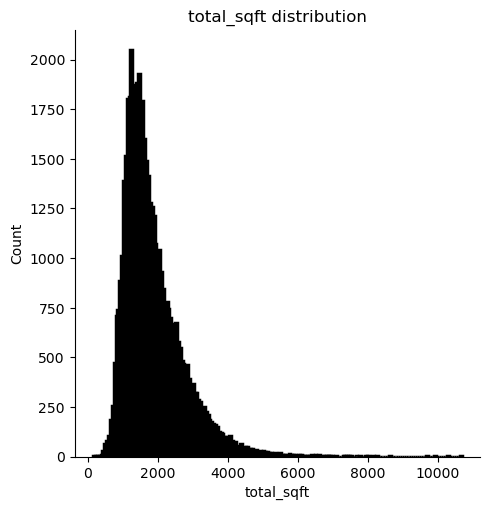

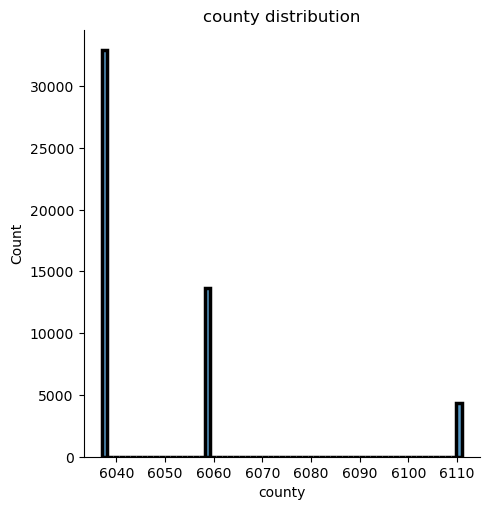

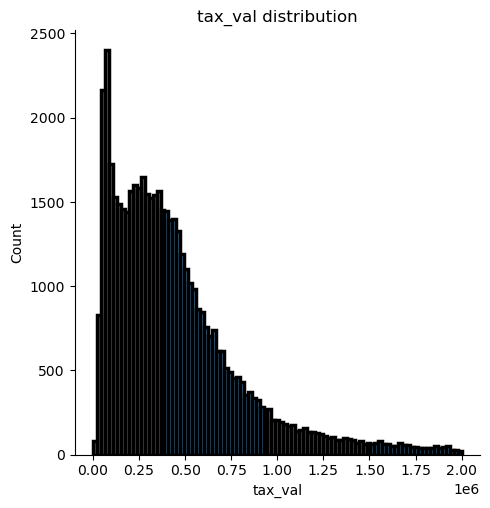

In [50]:
## visualising the data to look for outliers

for col in zil.columns:
    sns.displot(zil[col], palette = ['red', 'green'], linewidth=2.5)
    plt.title(f'{col} distribution')
    plt.show()

**TAKEAWAY : The tax value column appears to have a low number of major outliers, and is the only column with such. The county graphs are right-skewed, but there are only 3 counties included to begin with. The others are relatively normally distributed, though the date of sale shows a spike at the beginning of the year.**

In [39]:
# looking at outliers in tax_value

zil[zil.tax_val >= 2_000_000]

,date_sold,num_ba,num_br,total_sqft,county,tax_val
52358,2017-09-19,3.0,3.0,1687.0,6037,2000000.0


In [52]:
# pc of outliers for tax value

(1403 / 52442) * 100

2.675336562297395

**If setting the tax value at $2 million as the cutoff for outliers, then we eliminate 2.67pc of the data. This is deemed insignificant.**

In [51]:
# keeping homes with a tax value of 2_000_000 or less

zil = zil[zil.tax_val <= 2_000_000]
zil.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 50937 entries, 0 to 52441
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   date_sold   50937 non-null  object 
 1   num_ba      50937 non-null  float64
 2   num_br      50937 non-null  float64
 3   total_sqft  50937 non-null  float64
 4   county      50937 non-null  int64  
 5   tax_val     50937 non-null  float64
dtypes: float64(4), int64(1), object(1)
memory usage: 2.7+ MB


**After tidying, there are 50 937 rows and 6 columns.**

### Now it's time to split into train, validate and test subsets.

In [53]:
train, val, test = project_2_prepare_zillow_2017.tts_zillow(zil)
train.shape, val.shape, test.shape

((28524, 6), (12225, 6), (10188, 6))

### 3. Work through all of the steps outlined in the lesson, from setting the baseline to selecting a model and evaluating the final model on your test data. 

In [54]:
# split train, val, test into X_train, X_val, X_test (feature DF, exludes var 'survived') and y-train, etc

# y_train is only our target

# X_train is everything except for tax value

X_train = train.drop(columns = ['tax_val'])
y_train = train['tax_val']


X_val = val.drop(columns = ['tax_val'])
y_val = val['tax_val']


X_test = test.drop(columns = ['tax_val'])
y_test = test['tax_val']

